In [1]:
using Pkg, Polynomials
# enforce Polynomial package version
if Pkg.TOML.parsefile(joinpath(pkgdir(Polynomials), "Project.toml"))["version"] != "1.2.1"
    Pkg.add(name="Polynomials",version="1.2.1")
end

In [2]:
using LinearAlgebra, DifferentialEquations, SparseArrays, Polynomials, Plots

struct PiecewisePolynomial{T}
    x::Vector{T}
    p::Vector{Polynomial{T}}
end

struct CubicSpline{T}
    # FIXME: parametric type so CubicSpline is same type as its pwp element type
    pwp::PiecewisePolynomial{T}
    y # Would-be knot obscissas in absence of smoothing
    α # Smoothing parameter in (0,1)
    w # Weight scalar or vector
    #Js # Expected prediction error from leave-one-out cross validation
    periodic::Bool # Periodic extrapolation (as opposed to no extrapolation) 
end

struct CubicSplineProduct{T}
    s1::CubicSpline{T}
    s2::CubicSpline{T}
end

"Evaluate piecewise polynomial. Asserts x lies within closed interval defined by x[1] and x[end]"
function (pwp::PiecewisePolynomial)(x;der::Int=0)  # Type so PiecewisePolynomial has same type as x
    @assert pwp.x[1]<=x<=pwp.x[end]
    k=max(searchsortedfirst(pwp.x,x,lt=<)-1,1)  
    p=derivative(pwp.p[k],der)
    return p(x-pwp.x[k])  
end

"""Fit a possibly smoothed and possibly periodic cubic spline to points (x,y).
No smoothing if α=1 and linear if α=0. Amount of smoothing per point is determined by w."""
function CubicSpline(x::Vector{T},y::Vector{};periodic::Bool=true,α=1,w::Vector{T}=ones(T,length(x)-1))::CubicSpline{T} where T
    # Notation (almost) according to Zanetti "Periodic cubic smoothing splines as a quadratic minimization problem"
    n=length(x)
    h=diff(x)
    @assert n>=3
    @assert ~(0 in h)
    @assert length(w)==n-1
    
    # FIXME: should be able to store only one half of S,V since symmetric
    S=spdiagm(-1=>h[1:end-1],0=>2*(h+circshift(h,1)),1=>h[1:end-1])
    hi=1 ./h
    V=spdiagm(-1=>hi[1:end-1],0=>-hi-circshift(hi,1),1=>hi[1:end-1])
    if periodic # C2-periodicity conditions
        S[1,n-1]=h[end]=S[n-1,1]=h[end]    
        V[1,n-1]=V[n-1,1]=hi[end]
    else # Second derivatives at end point 0
        S[1,2]=S[n-1,n-2]=0
        V[1,1:2]=[0,0]
    end
    Q=ldlt(S)\V
    
    # Setup problem
    W=Diagonal(w) # FIXME: Doesn't deal with Infs in w (that arise from σ=0 for some measurements)
    U=2α*W+12*(1-α)*V'*Q # α corresponds to p in paper
    v=2α*W*y[1:end-1];

    # Solve for polynomial coefficients
    a=U\v
    c=3Q*a
    d=hi.*(circshift(c,-1)-c)./3
    b=hi.*(circshift(a,-1)-a)-c.*h-d.*h.^2
    
    #Σ=2α*inv(Matrix(U))
    #@show Σ*y[1:end-1] # Works but we should add final row that maps y[end] to last knot point

    # Store polynomials
    ps=[Polynomial([a[k],b[k],c[k],d[k]]) for k=1:n-1]
    pwp=PiecewisePolynomial(x,ps)
    return CubicSpline(pwp,y,α,w,periodic)
end

"Compute cubic spline (derivative) interpolation with scalar or vector argument."
function (s::CubicSpline{T})(x::T;der::Int=0) where T
    if s.periodic
        x=fold(x,s.pwp.x[1],s.pwp.x[end]) 
    else
        @assert s.pwp.x[1]<=x<=s.pwp.x[end]
    end
    return s.pwp(x,der=der)
end

import Base.*
"Define multiplication for CubicSpline"
s1::CubicSpline * s2::CubicSpline = CubicSplineProduct(s1,s2)

"Evaluate (derivative of) CubicSplineProduct"
function (sp::CubicSplineProduct{T})(x::T;der::Int=0) where T
    ret=0
    for k in 0:der
       ret+=binomial(der,k)*sp.s1(x,der=k)*sp.s2(x,der=der-k) # terms of the product chain rule
    end
    return ret
end

# Vectorized versions
function (s::Union{CubicSpline{T},CubicSplineProduct{T}})(x::Vector{T};der::Int=0) where T
    return s.(x,der=der)
end

"Periodically fold back value to range"
function fold(x,xmin,xmax)
    Δx=xmax-xmin
    x=(x-xmin) % Δx
    x=x<0 ? Δx+x : x;
    x+=xmin
end

#FIXME can use saveat argument with solve instead
"Calculate pwk4 DAE model ouput for time t"
function yhat(sol::DAESolution,C::Matrix{Float64},D::Float64,t::Vector)
    x = sol(t)[1:2,:]'
    u = sol(t)[3,:]'
    transpose(C*transpose(x) + D*u)[:]
end;

In [3]:
using DelimitedFiles

"write matrix d to file `filename.csv`, with `header` and `comment`."
function csvwrite(filename::String,d::Matrix;comment::String="",header=["x$(n)" for n in 1:size(d)[2]])
    h= string([s*"," for s in header]...)[1:end-1]
    s = isempty(comment) ? h*"\n" : "#"*comment*"\n"*h*"\n"
    open(filename*".csv","w") do f
        write(f, s)
        writedlm(f,d,',')
    end
end

csvwrite

In [4]:
# Digitized waveform from Stergiopulos et al 1999,
# "Total arterial inertance as the fourth element of the windkessel model"
# Figure 4, Type A, A and B
using CSV
prefix="stergiopulos1999_"
p=CSV.File(prefix*"pressure.csv", header=[:t,:v], types=[Float64, Float64]).v # mmHg
φ=(60/1000) .* CSV.File(prefix*"flow.csv", header=[:t,:v], types=[Float64, Float64]).v # L/min
h=0.005
t=collect(h.*(0:length(p)-1));

In [5]:
# Spline interpolations
αφ=1-1e-12 # FIXME: should be set using xval
αp=αφ # FIXME: should be set using xval
φc=CubicSpline(t,φ,periodic=true,α=αφ)
pc=CubicSpline(t,p,periodic=true,α=αp);

In [6]:
# Windkessel parameters
"Parallel 4-element windkessel human-data model parameters from  stergiopulos1999total."
function θwk4()
    Rp=0.79 # Peripheral (systemic) resistance [mmHg*ml^-1*s]
    C=1.22 # Total arterial compliance [ml/mmHg]
    Rc=0.056 # characeristic aoritic resistance
    L=0.0051 # Total arterial impedance [mmHg*s^2*ml^-1]
    return [1000/60,60/1000,1000/60,1000/60].*[Rp,C,Rc,L] # convert impedance units to match L/min flows 
end
(Rp,C,Rc,L)=θwk4()

# State space matrices (m not to confuse Cm with parameter C)
Am=[-1/(C*Rp) 0; 0 -Rc/L]
Bm=[1; Rc]
Cm=[1/C -Rc/L]
Dm=Rc;

In [7]:
# Standard Windkessel with cubic-spline-interpolated flow input

"Standard (flow input) 4-element parallel windkessel ODE"
function wk4p!(dx,x,θ,t)
    A,B,C,D=θ
    dx.=A*x+B*φc(t)
end

x0guess=[0,0] # 
θ=[Am,Bm,Cm,Dm]
Tmax=max(C*Rp,L/Rc) # Slowest time constant
nT=50
x0periods=ceil(Tmax*nT)
prob = ODEProblem(wk4p!,x0guess, (t[1],t[1]+x0periods*(t[end]-t[1])), θ)
sol=solve(prob,Tsit5())
x0=sol.u[end]

# Solve for one period in steady operation
prob = ODEProblem(wk4p!,x0,(t[1],t[end]),θ)
sol=solve(prob,Tsit5())
tsim=sol.t
xhat=sol.u;
phat=[dot(Cm,xhat[k])+dot(Dm,φc(tsim[k])) for k in 1:length(xhat)];

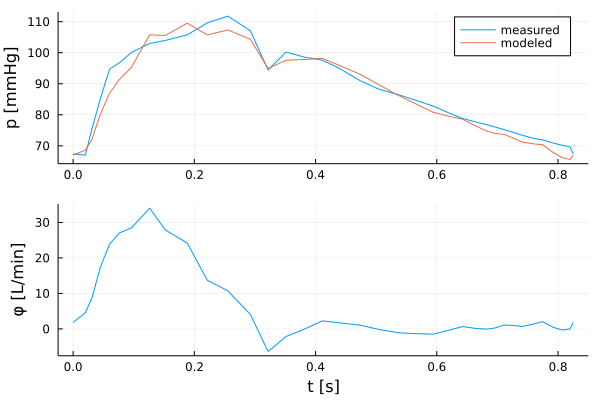

In [8]:
# Plot results
using Plots
p1=plot(tsim,pc(tsim),ylabel="p [mmHg]",label="measured")
plot!(p1,tsim,phat,label="modeled")
p2=plot(tsim,φc(tsim),legend=false,xlabel="t [s]",ylabel="φ [L/min]")
plot(p1,p2,layout=(2,1))

In [9]:
# Power input Windkessel using cubic-spline-interpolated flow and pressure
using DifferentialEquations, Sundials

# The power profile spline
wc=φc*pc

"Power input 4-element parallel windkessel DAE"
function wk4p_dae!(r,dz,z,θ,t)
    A,B,C,D=θ
    dx=dz[1:2]
    x=z[1:2]
    φ=z[3]
    r[1:2].=A*x+B*φ-dx
    p=dot(C,x)+D*φ
    r[3]=p*φ-wc(t)
end

x0guess=[0,0] # 
θ=[Am,Bm,Cm,Dm]
Tmax=max(C*Rp,L/Rc) # Slowest time constant
nT=50
x0periods=ceil(Tmax*nT)
prob = ODEProblem(wk4p!,x0guess, (t[1],t[1]+x0periods*(t[end]-t[1])), θ)
sol=solve(prob,Tsit5())
x0=sol.u[end]

# Solve for one period in steady operation
z0=[x0;0]
z0d=[0,0,0]
differential_vars=[true,true,false]
prob=DAEProblem(wk4p_dae!,z0d,z0,(t[1],10*t[end]),θ,differential_vars=differential_vars)
sol=solve(prob,IDA())
tsim=sol.t
zhat=sol.u
phat=[dot(Cm,zhat[k][1:2])+dot(Dm,zhat[k][3]) for k in 1:length(zhat)] # FIXME: use φc here or zhat[k][3]?
φhat=[zhat[k][3] for k in 1:length(zhat)]
what=phat.*φhat;

In [10]:
# resample
tsim = collect(t[1]:h:6*t[end])
phat=yhat(sol,Cm,Dm,tsim)
φhat=sol(tsim)[3,:]
what=phat.*φhat;

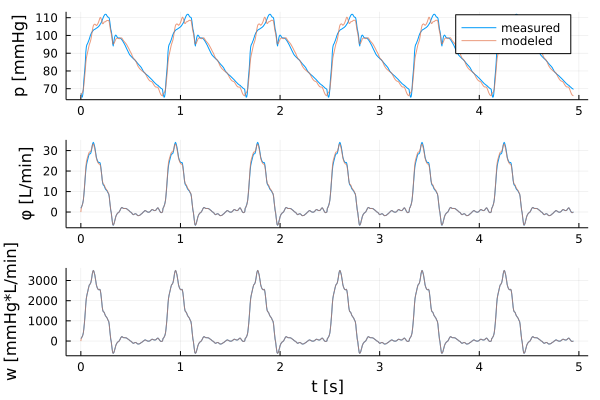

In [11]:
# Plot results
p1=plot(tsim,pc(tsim),ylabel="p [mmHg]",label="measured")
plot!(p1,tsim,phat,label="modeled",linealpha=0.7)
p2=plot(tsim,φc(tsim),legend=false,ylabel="φ [L/min]")
plot!(p2,tsim,φhat,linealpha=0.7)
p3=plot(tsim,wc(tsim),legend=false,xlabel="t [s]",ylabel="w [mmHg*L/min]")
plot!(p3,tsim,what,legend=false,linealpha=0.7)
plot(p1,p2,p3,layout=(3,1))

In [12]:
mmHgLpm_to_W(p) = p.*133.322/(1000*60);

In [13]:
co="t, sample time in seconds; p, pressure in mmHg; phi, flow in L/min, w, power in W; hat indicates modelled result"
he=["t","p","phat","phi","phihat","w","what"]
f="pwk4_normal"
d = hcat(tsim.-tsim[1],pc(tsim),phat,φc(tsim),φhat,mmHgLpm_to_W(wc(tsim)),mmHgLpm_to_W(what))
csvwrite(f,d,comment=co,header=he)

In [14]:
# Offset power input on 5th beat of 9 to simulate increased contractility
offset = vcat(zeros(length(t)*4),wc(t),zeros(length(t)*4))
ts = collect(h.*(0:length(offset)-1))
α=1-1e-12 # FIXME: should be set using xval
offsetc=CubicSpline(ts,offset,periodic=true,α=α)


# Simulate with scaled power profile spline

"Power input 4-element parallel windkessel DAE"
function wk4p_dae!(r,dz,z,θ,t)
    A,B,C,D=θ
    dx=dz[1:2]
    x=z[1:2]
    φ=z[3]
    r[1:2].=A*x+B*φ-dx
    p=dot(C,x)+D*φ
    r[3]=p*φ-(wc(t)+offsetc(t))
end

x0guess=[0,0]
θ=[Am,Bm,Cm,Dm]
prob = ODEProblem(wk4p!,x0guess, (ts[1],ts[end]), θ)
sol=solve(prob,Tsit5())
x0=sol.u[end]

# Solve for one period in steady operation
z0=[x0;0]
z0d=[0,0,0]
differential_vars=[true,true,false]
prob=DAEProblem(wk4p_dae!,z0d,z0,(ts[1],ts[end]),θ,differential_vars=differential_vars)
sol=solve(prob,IDA())
tsim=sol.t
zhat=sol.u
phat=[dot(Cm,zhat[k][1:2])+dot(Dm,zhat[k][3]) for k in 1:length(zhat)] # FIXME: use φsc here or zhat[k][3]?
φhat=[zhat[k][3] for k in 1:length(zhat)]
what=phat.*φhat;

In [15]:
# resample
tsim = collect(2*t[end]:h:8*t[end])
phat=yhat(sol,Cm,Dm,tsim)
φhat=sol(tsim)[3,:]
what=phat.*φhat;

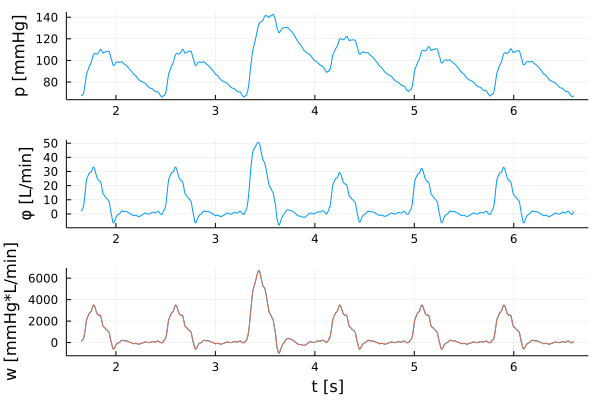

In [16]:
# Plot results
p1=plot(tsim,phat,ylabel="p [mmHg]",legend=:none)
p2=plot(tsim,φhat,legend=false,ylabel="φ [L/min]")
p3=plot(tsim,what,legend=false,xlabel="t [s]",ylabel="w [mmHg*L/min]")
plot!(p3,tsim,wc(tsim).+offsetc(tsim))
plot(p1,p2,p3,layout=(3,1))

In [17]:
co="t, sample time in seconds; p, pressure in mmHg; phi, flow in L/min, w, power in W; hat indicates modelled result"
he=["t","phat","phihat","w"]
f="pwk4_amp_scaled"
d = hcat(tsim.-tsim[1],phat,φhat,mmHgLpm_to_W(wc(tsim).+offsetc(tsim)))
csvwrite(f,d,comment=co,header=he)

In [18]:
# Premature 5th beat of 9 to simulate arrythmetic event
adjust(t_::Float64;shift=0.7) = t_>(4-shift)*t[end] ? (t_-(1-shift)*t[end]) : t_
adjust(t_::Vector;shift=0.7) = [tn>(4-shift)*t[end] ? (tn-(1-shift)*t[end]) : tn for tn in t_]
α=1-1e-12 # FIXME: should be set using xval
wcf=CubicSpline(ts,wc(adjust(ts)),periodic=true,α=α) 

# Simulate with time-adjusted power profile spline

"Power input 4-element parallel windkessel DAE"
function wk4p_dae!(r,dz,z,θ,t)
    A,B,C,D=θ
    dx=dz[1:2]
    x=z[1:2]
    φ=z[3]
    r[1:2].=A*x+B*φ-dx
    p=dot(C,x)+D*φ
    r[3]=p*φ-wcf(t)
end

x0guess=[0,0]
θ=[Am,Bm,Cm,Dm]
prob = ODEProblem(wk4p!,x0guess, (ts[1],ts[end]), θ)
sol=solve(prob,Tsit5())
x0=sol.u[end]

# Solve for one period in steady operation
z0=[x0;0]
z0d=[0,0,0]
differential_vars=[true,true,false]
prob=DAEProblem(wk4p_dae!,z0d,z0,(ts[1],ts[end]),θ,differential_vars=differential_vars)
sol=solve(prob,IDA())
tsim=sol.t
zhat=sol.u
phat=[dot(Cm,zhat[k][1:2])+dot(Dm,zhat[k][3]) for k in 1:length(zhat)] # FIXME: use φsc here or zhat[k][3]?
φhat=[zhat[k][3] for k in 1:length(zhat)]
what=phat.*φhat;

In [19]:
# resample
tsim = collect(1*t[end]:h:7*t[end])
phat=yhat(sol,Cm,Dm,tsim)
φhat=sol(tsim)[3,:]
what=phat.*φhat;

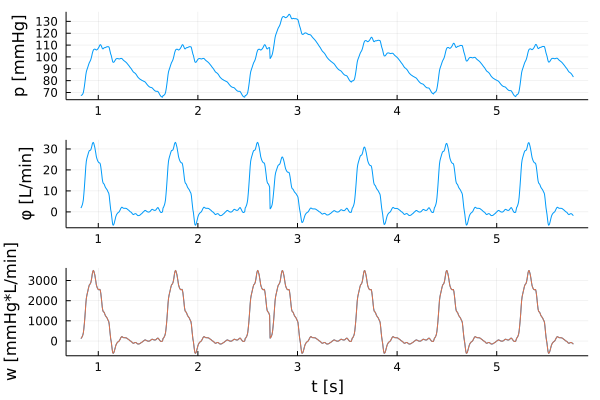

In [20]:
# Plot results
p1=plot(tsim,phat,ylabel="p [mmHg]",legend=:none)
p2=plot(tsim,φhat,legend=false,ylabel="φ [L/min]")
p3=plot(tsim,what,legend=false,xlabel="t [s]",ylabel="w [mmHg*L/min]")
plot!(p3,tsim,wcf(tsim))
plot(p1,p2,p3,layout=(3,1))

In [21]:
co="t, sample time in seconds; p, pressure in mmHg; phi, flow in L/min, w, power in W; hat indicates modelled result"
he=["t","phat","phihat","w"]
f="pwk4_premature"
d = hcat(tsim.-tsim[1],phat,φhat,mmHgLpm_to_W(wcf(tsim)))
csvwrite(f,d,comment=co,header=he)

In [22]:
# Double freqency on 4th and 5th beat of 9 to simulate arrhythmic event
adjust(t_::Float64) = 3<floor(t_/t[end])<=5 ? 2(t_%t[end]) : t_
adjust(t_::Vector) = [3<floor(tn/t[end])<=5 ? 2(tn%t[end]) : tn for tn in t_]

# Simulate with time-adjusted power profile spline

"Power input 4-element parallel windkessel DAE"
function wk4p_dae!(r,dz,z,θ,t)
    A,B,C,D=θ
    dx=dz[1:2]
    x=z[1:2]
    φ=z[3]
    r[1:2].=A*x+B*φ-dx
    p=dot(C,x)+D*φ
    r[3]=p*φ-wc(adjust(t))
end

x0guess=[0,0]
θ=[Am,Bm,Cm,Dm]
prob = ODEProblem(wk4p!,x0guess, (ts[1],ts[end]), θ)
sol=solve(prob,Tsit5())
x0=sol.u[end]

# Solve for one period in steady operation
z0=[x0;0]
z0d=[0,0,0]
differential_vars=[true,true,false]
prob=DAEProblem(wk4p_dae!,z0d,z0,(ts[1],ts[end]),θ,differential_vars=differential_vars)
sol=solve(prob,IDA())
tsim=sol.t
zhat=sol.u
phat=[dot(Cm,zhat[k][1:2])+dot(Dm,zhat[k][3]) for k in 1:length(zhat)] # FIXME: use φsc here or zhat[k][3]?
φhat=[zhat[k][3] for k in 1:length(zhat)]
what=phat.*φhat;

In [23]:
# resample
tsim = collect(2*t[end]:h:8*t[end])
phat=yhat(sol,Cm,Dm,tsim)
φhat=sol(tsim)[3,:]
what=phat.*φhat;

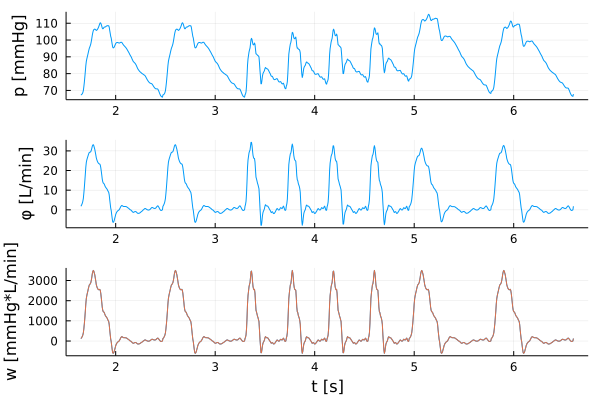

In [24]:
# Plot results
p1=plot(tsim,phat,ylabel="p [mmHg]",legend=:none)
p2=plot(tsim,φhat,legend=false,ylabel="φ [L/min]")
p3=plot(tsim,what,legend=false,xlabel="t [s]",ylabel="w [mmHg*L/min]")
plot!(p3,tsim,wc(adjust(tsim)))
plot(p1,p2,p3,layout=(3,1))

In [25]:
co="t, sample time in seconds; p, pressure in mmHg; phi, flow in L/min, w, power in W; hat indicates modelled result"
he=["t","phat","phihat","w"]
f="pwk4_freq_scaled"
d = hcat(tsim.-tsim[1],phat,φhat,mmHgLpm_to_W(wc(adjust(tsim))))
csvwrite(f,d,comment=co,header=he)

# Verify CubicSplineProduct

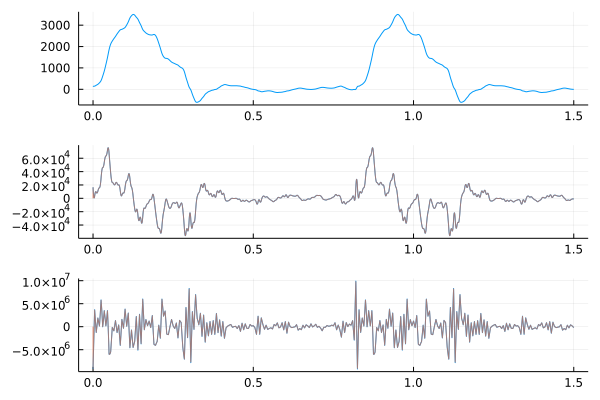

In [26]:
# Test to verify differentiation of CubpicSplineProduct against finite differences

# Continuous power signal
wc=φc*pc

# Hi-res time vector
t=collect(0:1e-4:1.5)

# Finite differnce derivatives
d=x->diff(x)
wcd=wc(t,der=1)
wcd_fd=[0;d(wc(t))./d(t)]
wcd2=wc(t,der=2)
wcd2_fd=[0;d(wcd)./d(t)]

# Comparison plot
p1=plot(t,wc(t),legend=false)
p2=plot(t,wcd,legend=false)
plot!(p2,t,wcd_fd,linealpha=0.7)
p3=plot(t,wcd2,legend=false)
plot!(p3,t,wcd2_fd,linealpha=0.7)
plot(p1,p2,p3,layout=(3,1))